# 5_Exp_Var_all_methods

In [1]:
from pathlib import Path
import sys
import os.path
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import f_oneway, gaussian_kde, mannwhitneyu, pearsonr, spearmanr
import seaborn as sns
from tqdm.notebook import tqdm
from pymodulon.compare import compare_ica
from pymodulon.core import IcaData
from pymodulon.io import load_json_model, save_to_json
from pymodulon.plotting import *

import json

from pymodulon.util import explained_variance
from pymodulon.imodulondb import imdb_gene_presence

%matplotlib inline
%config  InlineBackend.figure_format = 'png'

sns.set_style('whitegrid')

In [2]:
precise1k = load_json_model('../Data/p1k.json.gz')

In [6]:
def explained_variance_each_component(
    M_matrix, A_matrix, log_tpm , genes=None, samples=None, imodulons=None
):

    # Check inputs
    if genes is None:
        genes = log_tpm.index
    elif isinstance(genes, str):
        genes = [genes]

    if samples is None:
        samples = log_tpm.columns
    elif isinstance(samples, str):
        samples = [samples]

    if imodulons is None:
        imodulons = M_matrix.columns
    elif isinstance(imodulons, str) or isinstance(imodulons, int):
        imodulons = [imodulons]

    centered = log_tpm
    
    # Account for normalization procedures before ICA (X=SA-x_mean)
    baseline = centered.subtract(centered.mean(axis=0), axis=1)
    baseline = baseline.loc[genes, samples]

    # Initialize variables
    base_err = np.linalg.norm(baseline) ** 2
    MA = np.zeros(baseline.shape)
    rec_var = [0]
    ma_arrs = {}
    ma_weights = {}
    explained_variance = []
    i = 0
    
    # Get individual modulon contributions
    for k in imodulons:
        ma_arr = np.dot(
            M_matrix.loc[genes, k].values.reshape(len(genes), 1),
            A_matrix.loc[k, samples].values.reshape(1, len(samples)),
        )
        ma_arrs[k] = ma_arr
        ma_weights[k] = np.sum(ma_arr**2)

    # Calculate explained variance in the original order
    for k in imodulons:
        MA = MA + ma_arrs[k]
        sa_err = np.linalg.norm(MA - baseline) ** 2
        rec_var.append((1 - sa_err / base_err))
        explained_variance.append((k, rec_var[i+1] - rec_var[i]))
        i += 1

    # Create a DataFrame from the collected data without sorting by explained variance
    explained_variance_df = pd.DataFrame(explained_variance, columns=['iModulon', 'Explained Variance'])
    
    return explained_variance_df

## Principal Component Analysis

In [4]:
components_pca = pd.read_csv('./Results/PCA/M_PCA.csv', index_col=0)

In [5]:
activities_pca = pd.read_csv('./Results/PCA/A_PCA.csv', index_col=0).T

In [7]:
PCA_explained_variance = explained_variance_each_component(components_pca, activities_pca, precise1k.X)

In [8]:
PCA_explained_variance

,iModulon,Explained Variance
0,Component_1,0.290072
1,Component_2,0.114001
2,Component_3,0.094801
3,Component_4,0.057818
4,Component_5,0.046460
...,...,...
245,Component_246,0.000098
246,Component_247,0.000097
247,Component_248,0.000097
248,Component_249,0.000096


## Independent Principal Component Analysis

In [10]:
components_ipca = pd.read_csv('./Results/IPCA/components_ipca.csv', index_col=0)

In [11]:
activities_ipca = pd.read_csv('./Results/IPCA/loadings_variables_ipca.csv', index_col=0).T

In [22]:
IPCA_explained_variance = explained_variance_each_component(components_ipca, activities_ipca, precise1k.X)

In [23]:
IPCA_explained_variance

,iModulon,Explained Variance
0,IPC1,8.212769e-07
1,IPC2,4.610091e-07
2,IPC3,8.013879e-07
3,IPC4,7.753888e-07
4,IPC5,4.721739e-07
...,...,...
245,IPC246,2.867657e-07
246,IPC247,2.964287e-07
247,IPC248,2.984583e-07
248,IPC249,2.976146e-07


## sparse IPCA

In [24]:
components_sipca = pd.read_csv('./Results/sIPCA/components_sipca.csv', index_col=0)

In [25]:
activities_sipca = pd.read_csv('./Results/sIPCA/loadings_variables_sipca.csv', index_col=0).T

In [26]:
activities_sipca.index = components_sipca.columns

In [27]:
sIPCA_explained_variance = explained_variance_each_component(components_sipca, activities_sipca, precise1k.X)

In [28]:
sIPCA_explained_variance

,iModulon,Explained Variance
0,IPC 1,8.130004e-07
1,IPC 2,4.016788e-07
2,IPC 3,7.337181e-07
3,IPC 4,8.118782e-07
4,IPC 5,4.136397e-07
...,...,...
245,IPC 246,2.301792e-08
246,IPC 247,2.214125e-08
247,IPC 248,1.994395e-08
248,IPC 249,1.829524e-07


## Factor Analysis

In [30]:
components_factor_analysis = pd.read_csv('./Results/Factor_Analysis/M_Factor_Analysis.csv', index_col=0)

In [31]:
activities_factor_analysis = pd.read_csv('./Results/Factor_Analysis/A_Factor_Analysis.csv', index_col=0).T

In [32]:
factor_analysis_explained_variance = explained_variance_each_component(components_factor_analysis, activities_factor_analysis, precise1k.X)

In [33]:
factor_analysis_explained_variance

,iModulon,Explained Variance
0,Component_1,0.156821
1,Component_2,0.030974
2,Component_3,0.003256
3,Component_4,0.004981
4,Component_5,0.002752
...,...,...
245,Component_246,0.000084
246,Component_247,0.000088
247,Component_248,0.000082
248,Component_249,0.000084


## Dictionary Learning

In [34]:
components_dictionary_learning = pd.read_csv('./Results/Dictionary_Learning/M_Dictionary_Learning.csv', index_col=0)

In [35]:
activities_dictionary_learning = pd.read_csv('./Results/Dictionary_Learning/A_Dictionary_Learning.csv', index_col=0).T

In [36]:
dictionary_learning_explained_variance = explained_variance_each_component(components_dictionary_learning, activities_dictionary_learning, precise1k.X)

In [37]:
dictionary_learning_explained_variance

,iModulon,Explained Variance
0,Component_1,0.015061
1,Component_2,0.021113
2,Component_3,0.022684
3,Component_4,0.009116
4,Component_5,0.002443
...,...,...
245,Component_246,0.000761
246,Component_247,0.002756
247,Component_248,0.003909
248,Component_249,0.008274


## SparseCoder

In [39]:
components_SparseCoder = pd.read_csv('./Results/SparseCoder/M_SparseCoder.csv', index_col=0)

In [40]:
activities_SparseCoder = pd.read_csv('./Results/SparseCoder/A_SparseCoder.csv', index_col=0).T

In [41]:
SparseCoder_explained_variance = explained_variance_each_component(components_SparseCoder, activities_SparseCoder, precise1k.X)

In [42]:
SparseCoder_explained_variance

,iModulon,Explained Variance
0,Component_1,0.015061
1,Component_2,0.021113
2,Component_3,0.022684
3,Component_4,0.009116
4,Component_5,0.002443
...,...,...
245,Component_246,0.000761
246,Component_247,0.002756
247,Component_248,0.003909
248,Component_249,0.008274


## Incremental Principal Component Analysis

In [44]:
components_incremental_pca = pd.read_csv('./Results/IncrementalPCA/M_IncrementalPCA.csv', index_col=0)

In [45]:
activities_incremental_pca = pd.read_csv('./Results/IncrementalPCA/A_IncrementalPCA.csv', index_col=0).T

In [46]:
incremental_pca_explained_variance = explained_variance_each_component(components_incremental_pca, activities_incremental_pca, precise1k.X)

In [47]:
incremental_pca_explained_variance

,iModulon,Explained Variance
0,Component_1,0.290072
1,Component_2,0.114001
2,Component_3,0.094801
3,Component_4,0.057818
4,Component_5,0.046460
...,...,...
245,Component_246,0.000105
246,Component_247,0.000105
247,Component_248,0.000104
248,Component_249,0.000103


## FastICA

In [48]:
components_Fast_ICA = pd.read_csv('./Results/Fast_ICA/M_Fast_ICA.csv', index_col=0)

In [49]:
activities_Fast_ICA = pd.read_csv('./Results/Fast_ICA/A_Fast_ICA.csv', index_col=0).T

In [50]:
Fast_ICA_explained_variance = explained_variance_each_component(components_Fast_ICA, activities_Fast_ICA, precise1k.X)

In [51]:
Fast_ICA_explained_variance

,iModulon,Explained Variance
0,Component_1,0.002425
1,Component_2,0.000501
2,Component_3,0.008790
3,Component_4,0.003086
4,Component_5,0.001186
...,...,...
245,Component_246,0.001587
246,Component_247,0.008582
247,Component_248,0.000829
248,Component_249,0.001490


## Sparse ICA

In [58]:
components_Sparse_ICA = pd.read_csv('./Results/Sparse_ICA_R/Dim_250/S_sparse_ICA_0_8.csv')

In [59]:
components_Sparse_ICA.index = precise1k.X.index

In [60]:
activities_Sparse_ICA = pd.read_csv('./Results/Sparse_ICA_R/Dim_250/A_sparse_ICA_0_8.csv')

In [61]:
activities_Sparse_ICA.index = components_Sparse_ICA.columns

In [62]:
Sparse_ICA_explained_variance = explained_variance_each_component(components_Sparse_ICA, activities_Sparse_ICA, precise1k.X)

In [63]:
Sparse_ICA_explained_variance

,iModulon,Explained Variance
0,V1,0.000720
1,V2,0.001640
2,V3,0.003230
3,V4,0.002199
4,V5,0.001474
...,...,...
245,V246,0.005501
246,V247,0.001353
247,V248,0.007559
248,V249,0.001395


## InfoMax ICA

In [64]:
components_InfoMax_ICA = pd.read_csv('./Results/InfoMax_ICA/proc_S.csv').T

In [65]:
components_InfoMax_ICA.index = precise1k.X.index

In [66]:
activities_InfoMax_ICA = pd.read_csv('./Results/InfoMax_ICA/proc_A.csv')

In [67]:
activities_InfoMax_ICA.columns = precise1k.X.columns

In [68]:
components_InfoMax_ICA.columns = activities_InfoMax_ICA.index

In [73]:
InfoMax_ICA_explained_variance = explained_variance_each_component(components_InfoMax_ICA, activities_InfoMax_ICA, precise1k.X)

In [74]:
InfoMax_ICA_explained_variance

,iModulon,Explained Variance
0,0,0.041331
1,1,0.018525
2,2,0.013703
3,3,0.009819
4,4,0.015056
...,...,...
245,245,0.000550
246,246,0.000486
247,247,0.000499
248,248,0.000477


## NMF

In [76]:
components_NMF = pd.read_csv('./Results/NMF/M_NMF.csv', index_col=0)

In [77]:
activities_NMF = pd.read_csv('./Results/NMF/A_NMF.csv', index_col=0).T

In [78]:
NMF_explained_variance = explained_variance_each_component(components_NMF, activities_NMF, precise1k.X)

In [79]:
NMF_explained_variance

,iModulon,Explained Variance
0,Component_1,-1.929845
1,Component_2,-0.056140
2,Component_3,-0.263809
3,Component_4,-0.076488
4,Component_5,-0.057049
...,...,...
245,Component_246,-0.116657
246,Component_247,-0.118131
247,Component_248,-0.046003
248,Component_249,-0.025747


## Picard ICA

In [80]:
components_Picard_ICA = pd.read_csv('./Results/Picard_ICA/proc_S.csv').T

In [81]:
components_Picard_ICA.index = precise1k.X.index

In [82]:
activities_Picard_ICA = pd.read_csv('./Results/Picard_ICA/proc_A.csv')

In [83]:
activities_Picard_ICA.columns = precise1k.X.columns

In [84]:
components_Picard_ICA.columns = activities_Picard_ICA.index

In [85]:
Picard_ICA_explained_variance = explained_variance_each_component(components_Picard_ICA, activities_Picard_ICA, precise1k.X)

In [86]:
Picard_ICA_explained_variance

,iModulon,Explained Variance
0,0,0.023638
1,1,0.012080
2,2,0.011979
3,3,0.012388
4,4,0.009017
...,...,...
245,245,0.000453
246,246,0.000443
247,247,0.000354
248,248,0.000347


## Sum of Exp Var

In [113]:
def calculate_sum_of_variances(dataframes: Dict[str, pd.DataFrame]) -> Dict[str, float]:
    """
    Calculates the sum of the 'Explained Variance' column in each provided dataframe.
    
    Parameters:
    dataframes (Dict[str, pd.DataFrame]): A dictionary where the keys are the method names and the values are the corresponding dataframes.

    Returns:
    Dict[str, float]: A dictionary with method names as keys and their corresponding sum of 'Explained Variance' values as values.
    """
    sum_dict = {}
    
    for method_name, df in dataframes.items():
        sum_value = df['Explained Variance'].sum()
        sum_dict[method_name] = sum_value
    
    return sum_dict

In [108]:
sum_exp_var = calculate_sum_of_variances(dataframes_dict)

In [109]:
sum_exp_var

{'PCA': 0.9773929746051151,
 'Incremental PCA': 0.9776315813713764,
 'Independent PCA': 0.00014441529368169892,
 'Sparse Independent PCA': 0.00010286532068926046,
 'Fast ICA': 0.9776315813713765,
 'InfoMax ICA': 0.665104016836261,
 'Picard ICA': 0.6651040168362612,
 'Sparse ICA': 0.7489040854551958,
 'NMF': -20.61833196378741,
 'Factor Analysis': 0.9729593694263614,
 'Dictionary Learning': 0.9032879365766188,
 'Sparse Coder': 0.9032879365766188}

In [110]:
sum_exp_var['NMF'] = 0

In [111]:
sum_exp_var

{'PCA': 0.9773929746051151,
 'Incremental PCA': 0.9776315813713764,
 'Independent PCA': 0.00014441529368169892,
 'Sparse Independent PCA': 0.00010286532068926046,
 'Fast ICA': 0.9776315813713765,
 'InfoMax ICA': 0.665104016836261,
 'Picard ICA': 0.6651040168362612,
 'Sparse ICA': 0.7489040854551958,
 'NMF': 0,
 'Factor Analysis': 0.9729593694263614,
 'Dictionary Learning': 0.9032879365766188,
 'Sparse Coder': 0.9032879365766188}

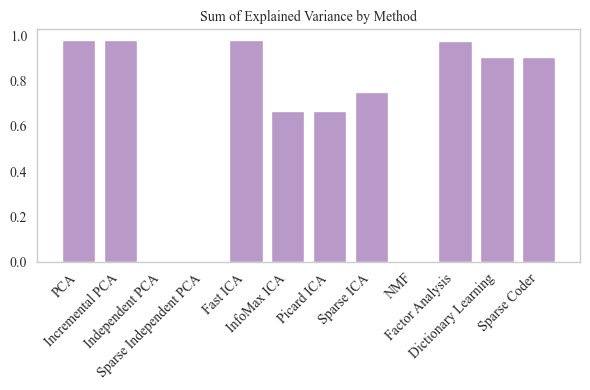

In [112]:
import matplotlib.font_manager as fm

def plot_sum_of_variances_with_style(sum_results: Dict[str, float]):
    """
    Plots the sum of explained variances for different methods with a specific style.
    
    Parameters:
    sum_results (Dict[str, float]): A dictionary with method names as keys and their corresponding sum of 'Explained Variance' values as values.
    """
    # Load custom font
    font_path = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
    font_prop = fm.FontProperties(fname=font_path)
    
    # Extract keys and values
    methods = list(sum_results.keys())
    sums = list(sum_results.values())
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(6, 4))
    
    # Bar plot
    ax.bar(methods, sums, color='#B999C8')
    
    # Set x-tick positions and labels to the method names
    ax.set_xticks(range(len(methods)))
    ax.set_xticklabels(methods, fontproperties=font_prop, rotation=45, ha="right")
    
    # Apply the font to y-axis ticks
    ax.yaxis.set_tick_params(labelsize=12)  # Optionally, set tick size
    for label in ax.get_yticklabels():
        label.set_fontproperties(font_prop)
    
    # Add title and labels
    ax.set_title("Sum of Explained Variance by Method", fontproperties=font_prop)
    
    # Remove grid lines
    ax.grid(False)
    
    # Add a width=1 box around the plot
    ax.spines['top'].set_linewidth(1)
    ax.spines['right'].set_linewidth(1)
    ax.spines['bottom'].set_linewidth(1)
    ax.spines['left'].set_linewidth(1)
    
    # Display the plot
    plt.tight_layout()
    plt.show()

plot_sum_of_variances_with_style(sum_exp_var)



## Calculate Coefficient of Variation (CV) for all exp var

To account for the scale and ensure that the relative variance is comparable, you could normalize or standardize the data before calculating the MAD. One common approach is to calculate the Coefficient of Variation (CV), which normalizes the MAD by dividing it by the mean:

In [116]:
from typing import Dict

def calculate_cv_for_variances(dataframes: Dict[str, pd.DataFrame]) -> Dict[str, float]:
    """
    Calculates the Coefficient of Variation (CV) for the 'Explained Variance' column in each provided dataframe.
    
    Parameters:
    dataframes (Dict[str, pd.DataFrame]): A dictionary where the keys are the method names and the values are the corresponding dataframes.

    Returns:
    Dict[str, float]: A dictionary with method names as keys and their corresponding CV values as values.
    """
    cv_dict = {}
    
    for method_name, df in dataframes.items():
        mean_value = df['Explained Variance'].mean()
        mad_value = df['Explained Variance'].mad()
        cv_value = mad_value / mean_value
        cv_dict[method_name] = abs(cv_value)
    
    return cv_dict

In [117]:
dataframes_dict = {
    'PCA': PCA_explained_variance,
    'Incremental PCA': incremental_pca_explained_variance,
    'Independent PCA': IPCA_explained_variance,
    'Sparse Independent PCA': sIPCA_explained_variance,
    'Fast ICA': Fast_ICA_explained_variance,
    'InfoMax ICA': InfoMax_ICA_explained_variance,
    'Picard ICA': Picard_ICA_explained_variance,
    'Sparse ICA': Sparse_ICA_explained_variance,
    'NMF': NMF_explained_variance,
    'Factor Analysis': factor_analysis_explained_variance,
    'Dictionary Learning': dictionary_learning_explained_variance,
    'Sparse Coder': SparseCoder_explained_variance
}

In [118]:
coefficient_of_variation_exp_var_per_components = calculate_cv_for_variances(dataframes_dict)

In [119]:
coefficient_of_variation_exp_var_per_components

{'PCA': 1.5543700680768,
 'Incremental PCA': 1.5539418857464145,
 'Independent PCA': 0.3785420482638874,
 'Sparse Independent PCA': 0.5647240459088939,
 'Fast ICA': 0.8088495713288201,
 'InfoMax ICA': 0.7711659599045133,
 'Picard ICA': 0.5847961615070819,
 'Sparse ICA': 0.8793467287515502,
 'NMF': 0.3970965477821813,
 'Factor Analysis': 1.5274883449377958,
 'Dictionary Learning': 0.5874579446155792,
 'Sparse Coder': 0.5874579446155792}

In [122]:
del coefficient_of_variation_exp_var_per_components['NMF']

In [123]:
del coefficient_of_variation_exp_var_per_components['Independent PCA']

In [124]:
del coefficient_of_variation_exp_var_per_components['Sparse Independent PCA']

In [129]:
def plot_cv_of_variances_with_style(cv_results: Dict[str, float]):
    """
    Plots the Coefficient of Variation (CV) for explained variances for different methods with a specific style.
    
    Parameters:
    cv_results (Dict[str, float]): A dictionary with method names as keys and their corresponding CV values as values.
    """
    # Load custom font
    font_path = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
    font_prop = fm.FontProperties(fname=font_path)
    
    # Extract keys and values
    methods = list(cv_results.keys())
    cvs = list(cv_results.values())
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(6, 4))
    
    # Bar plot with the specified color
    ax.bar(methods, cvs, color='#F6CD82')
    
    # Set x-tick positions and labels to the method names
    ax.set_xticks(range(len(methods)))
    ax.set_xticklabels(methods, fontproperties=font_prop, rotation=45, ha="right")
    
    # Apply the font to y-axis ticks
    ax.yaxis.set_tick_params(labelsize=12)  # Optionally, set tick size
    for label in ax.get_yticklabels():
        label.set_fontproperties(font_prop)
    
    # Add title and labels
    # ax.set_title("Coefficient of Variation of Explained Variance by Method", fontproperties=font_prop)
    ax.set_title("", fontproperties=font_prop)
    # Remove grid lines
    ax.grid(False)
    
    # Add a width=1 box around the plot
    ax.spines['top'].set_linewidth(1)
    ax.spines['right'].set_linewidth(1)
    ax.spines['bottom'].set_linewidth(1)
    ax.spines['left'].set_linewidth(1)
    
    # Display the plot
    plt.tight_layout()

    plt.savefig('coefficient_of_variation_exp_var.svg', format = 'svg')
    
    plt.show()

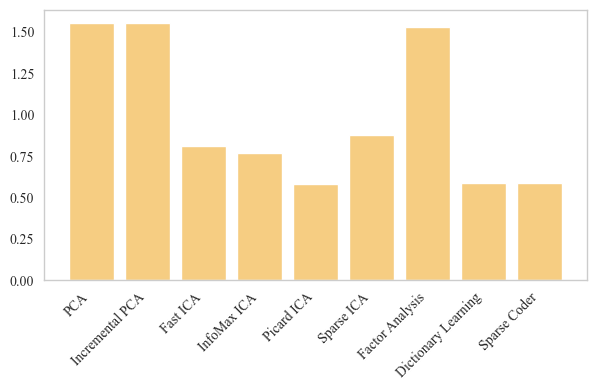

In [130]:
plot_cv_of_variances_with_style(coefficient_of_variation_exp_var_per_components)

## Sum of Exp Var

In [113]:
def calculate_sum_of_variances(dataframes: Dict[str, pd.DataFrame]) -> Dict[str, float]:
    """
    Calculates the sum of the 'Explained Variance' column in each provided dataframe.
    
    Parameters:
    dataframes (Dict[str, pd.DataFrame]): A dictionary where the keys are the method names and the values are the corresponding dataframes.

    Returns:
    Dict[str, float]: A dictionary with method names as keys and their corresponding sum of 'Explained Variance' values as values.
    """
    sum_dict = {}
    
    for method_name, df in dataframes.items():
        sum_value = df['Explained Variance'].sum()
        sum_dict[method_name] = sum_value
    
    return sum_dict

In [108]:
sum_exp_var = calculate_sum_of_variances(dataframes_dict)

In [109]:
sum_exp_var

{'PCA': 0.9773929746051151,
 'Incremental PCA': 0.9776315813713764,
 'Independent PCA': 0.00014441529368169892,
 'Sparse Independent PCA': 0.00010286532068926046,
 'Fast ICA': 0.9776315813713765,
 'InfoMax ICA': 0.665104016836261,
 'Picard ICA': 0.6651040168362612,
 'Sparse ICA': 0.7489040854551958,
 'NMF': -20.61833196378741,
 'Factor Analysis': 0.9729593694263614,
 'Dictionary Learning': 0.9032879365766188,
 'Sparse Coder': 0.9032879365766188}

In [110]:
sum_exp_var['NMF'] = 0

In [111]:
sum_exp_var

{'PCA': 0.9773929746051151,
 'Incremental PCA': 0.9776315813713764,
 'Independent PCA': 0.00014441529368169892,
 'Sparse Independent PCA': 0.00010286532068926046,
 'Fast ICA': 0.9776315813713765,
 'InfoMax ICA': 0.665104016836261,
 'Picard ICA': 0.6651040168362612,
 'Sparse ICA': 0.7489040854551958,
 'NMF': 0,
 'Factor Analysis': 0.9729593694263614,
 'Dictionary Learning': 0.9032879365766188,
 'Sparse Coder': 0.9032879365766188}

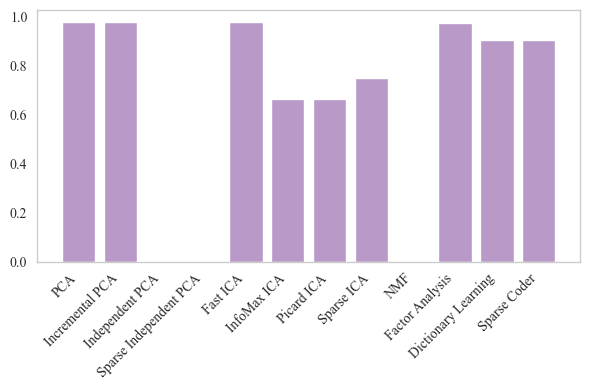

In [131]:
import matplotlib.font_manager as fm

def plot_sum_of_variances_with_style(sum_results: Dict[str, float]):
    """
    Plots the sum of explained variances for different methods with a specific style.
    
    Parameters:
    sum_results (Dict[str, float]): A dictionary with method names as keys and their corresponding sum of 'Explained Variance' values as values.
    """
    # Load custom font
    font_path = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
    font_prop = fm.FontProperties(fname=font_path)
    
    # Extract keys and values
    methods = list(sum_results.keys())
    sums = list(sum_results.values())
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(6, 4))
    
    # Bar plot
    ax.bar(methods, sums, color='#B999C8')
    
    # Set x-tick positions and labels to the method names
    ax.set_xticks(range(len(methods)))
    ax.set_xticklabels(methods, fontproperties=font_prop, rotation=45, ha="right")
    
    # Apply the font to y-axis ticks
    ax.yaxis.set_tick_params(labelsize=12)  # Optionally, set tick size
    for label in ax.get_yticklabels():
        label.set_fontproperties(font_prop)
    
    # Add title and labels
    # ax.set_title("Sum of Explained Variance by Method", fontproperties=font_prop)
    ax.set_title("", fontproperties=font_prop)
    
    # Remove grid lines
    ax.grid(False)
    
    # Add a width=1 box around the plot
    ax.spines['top'].set_linewidth(1)
    ax.spines['right'].set_linewidth(1)
    ax.spines['bottom'].set_linewidth(1)
    ax.spines['left'].set_linewidth(1)
    
    # Display the plot
    plt.tight_layout()
    plt.savefig('sum_of_exp_var.svg', format = 'svg')
    plt.show()

plot_sum_of_variances_with_style(sum_exp_var)

